# **Set up**

Downloading packages and loading in the dataset

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install huggingface_hub
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install torchmetrics
!git clone https://github.com/ramybaly/Article-Bias-Prediction.git

     |████████████████████████████████| 132 kB 12.2 MB/s 
     |████████████████████████████████| 1.2 MB 26.6 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
     |████████████████████████████████| 79 kB 5.0 MB/s 
     |████████████████████████████████| 8.7 MB 85.3 MB/s 
     |████████████████████████████████| 138 kB 84.5 MB/s 
     |████████████████████████████████| 127 kB 79.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 4.0 MB 14.9 MB/s 
     |████████████████████████████████| 596 kB 82.8 MB/s

In [ ]:
%load_ext autoreload
%autoreload 2
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Final Project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', 'data.py', 'engine.py', 'model.py']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

# **Creating Dataset**


Some toy example showing what tokenizer does.

Padding: sometime text in the batch are not of the same legnth, need [pad] token.

Truncate: Bert can only handle max of 512 tokens at a time. Setting truncate to True would truncate the text in batch to max lenght.

More detail: https://huggingface.co/docs/transformers/preprocessing

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text1 = "Replace me by any text you'd like."
text2 = "Hello World!"
text3 = "This is literal hell. This is another sentence."
batch = [text1, text2, text3]
encoded_input = tokenizer(batch, padding=True, return_tensors="pt")
print(tokenizer.get_vocab())
for k, v in encoded_input.items():
    print(k, v)
for sent in encoded_input['input_ids']:
    print(tokenizer.decode(sent))

{'[PAD]': 0, '[unused0]': 1, '[unused1]': 2, '[unused2]': 3, '[unused3]': 4, '[unused4]': 5, '[unused5]': 6, '[unused6]': 7, '[unused7]': 8, '[unused8]': 9, '[unused9]': 10, '[unused10]': 11, '[unused11]': 12, '[unused12]': 13, '[unused13]': 14, '[unused14]': 15, '[unused15]': 16, '[unused16]': 17, '[unused17]': 18, '[unused18]': 19, '[unused19]': 20, '[unused20]': 21, '[unused21]': 22, '[unused22]': 23, '[unused23]': 24, '[unused24]': 25, '[unused25]': 26, '[unused26]': 27, '[unused27]': 28, '[unused28]': 29, '[unused29]': 30, '[unused30]': 31, '[unused31]': 32, '[unused32]': 33, '[unused33]': 34, '[unused34]': 35, '[unused35]': 36, '[unused36]': 37, '[unused37]': 38, '[unused38]': 39, '[unused39]': 40, '[unused40]': 41, '[unused41]': 42, '[unused42]': 43, '[unused43]': 44, '[unused44]': 45, '[unused45]': 46, '[unused46]': 47, '[unused47]': 48, '[unused48]': 49, '[unused49]': 50, '[unused50]': 51, '[unused51]': 52, '[unused52]': 53, '[unused53]': 54, '[unused54]': 55, '[unused55]': 56

Creating dataset from data.py

In [ ]:
from data import ArticleBiasDS
from pathlib import Path
DATAPATH = Path("Article-Bias-Prediction/data")
dataset = ArticleBiasDS(DATAPATH/"jsons", 10000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10000/10000 [15:10<00:00, 10.99it/s]


Verification on the shape of data

In [ ]:
idx = 3
data_pt = dataset[idx]
data, label = data_pt
print(data.shape)

torch.Size([1147, 768])


#**Creating Dataloader**

In [ ]:
from data import get_loader
train_loader, val_loader, test_loader = get_loader(dataset)

# **Creating Model** 

All the following models

*   Baseline
*   Baseline+
*   RNN
*   RNN+

uses BERT as a word embedding generator.


In [ ]:
from transformers import BertModel
model = BertModel.from_pretrained("bert-base-uncased")
output = model(**encoded_input)
print("Output len:", len(output))
print("Output 0 shape:", output[0].shape)
print("Output 1 shape:", output[1].shape)
print(encoded_input)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Output len: 2
Output 0 shape: torch.Size([3, 12, 768])
Output 1 shape: torch.Size([3, 768])
{'input_ids': tensor([[  101,  5672,  2033,  2011,  2151,  3793,  2017,  1005,  1040,  2066,
          1012,   102],
        [  101,  7592,  2088,   999,   102,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2023,  2003, 18204,  3109,  1012,  2023,  2003,  2178,  6251,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


#**Media Bias Neural Network**


In [ ]:
from model import MediaBiasNN

# Training

epoch 0 loss: 927.5759887695312
epoch 1 loss: 454.8034973144531
epoch 2 loss: 351.37420654296875
epoch 3 loss: 276.47576904296875
epoch 4 loss: 225.43557739257812
epoch 5 loss: 197.16168212890625
epoch 6 loss: 165.54930114746094
epoch 7 loss: 155.67276000976562
epoch 8 loss: 142.4513702392578
epoch 9 loss: 134.47039794921875
epoch 10 loss: 122.3758316040039
epoch 11 loss: 110.71746063232422
epoch 12 loss: 113.28922271728516
epoch 13 loss: 147.4945831298828
epoch 14 loss: 122.79900360107422
epoch 15 loss: 84.54386901855469
epoch 16 loss: 85.2022705078125
epoch 17 loss: 100.7798843383789
epoch 18 loss: 131.82205200195312
epoch 19 loss: 138.93910217285156


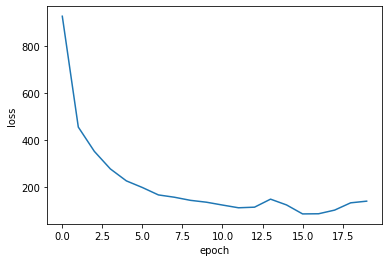

epoch 0 loss: 1454.2115478515625
epoch 1 loss: 741.2930908203125
epoch 2 loss: 527.3416137695312
epoch 3 loss: 421.208984375
epoch 4 loss: 391.0265197753906
epoch 5 loss: 417.2370300292969
epoch 6 loss: 399.5028076171875
epoch 7 loss: 480.6420593261719
epoch 8 loss: 351.0316162109375
epoch 9 loss: 309.5687255859375
epoch 10 loss: 329.1388854980469
epoch 11 loss: 273.687255859375
epoch 12 loss: 266.7240905761719
epoch 13 loss: 342.72216796875
epoch 14 loss: 390.2330017089844
epoch 15 loss: 131.00926208496094
epoch 16 loss: 146.51010131835938
epoch 17 loss: 142.2841339111328
epoch 18 loss: 183.13563537597656
epoch 19 loss: 275.269775390625


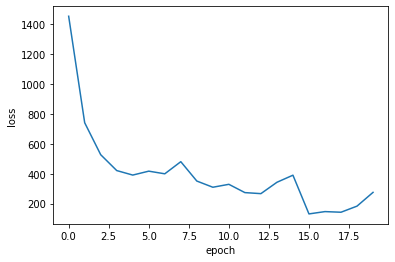

epoch 0 loss: 757.5484008789062
epoch 1 loss: 419.93499755859375
epoch 2 loss: 304.06427001953125
epoch 3 loss: 240.04978942871094
epoch 4 loss: 227.7315216064453
epoch 5 loss: 190.69493103027344
epoch 6 loss: 169.4180908203125
epoch 7 loss: 144.43011474609375
epoch 8 loss: 139.0508575439453
epoch 9 loss: 154.81117248535156
epoch 10 loss: 186.97702026367188
epoch 11 loss: 193.42697143554688
epoch 12 loss: 150.76339721679688
epoch 13 loss: 124.24748229980469
epoch 14 loss: 123.9157943725586
epoch 15 loss: 130.909912109375
epoch 16 loss: 83.5057601928711
epoch 17 loss: 77.41849517822266
epoch 18 loss: 80.78209686279297
epoch 19 loss: 83.62117004394531


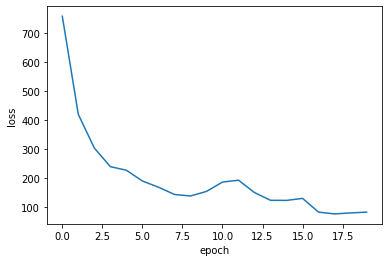

epoch 0 loss: 1618.765625
epoch 1 loss: 852.485595703125
epoch 2 loss: 658.4751586914062
epoch 3 loss: 490.9596252441406
epoch 4 loss: 428.11297607421875
epoch 5 loss: 417.5216979980469
epoch 6 loss: 482.9090270996094
epoch 7 loss: 384.5150451660156
epoch 8 loss: 313.33624267578125
epoch 9 loss: 239.3190155029297
epoch 10 loss: 202.81988525390625
epoch 11 loss: 166.16494750976562
epoch 12 loss: 294.9707336425781
epoch 13 loss: 309.1782531738281
epoch 14 loss: 225.040283203125
epoch 15 loss: 420.421142578125
epoch 16 loss: 306.283935546875
epoch 17 loss: 351.2538757324219
epoch 18 loss: 241.4481658935547
epoch 19 loss: 262.8370056152344


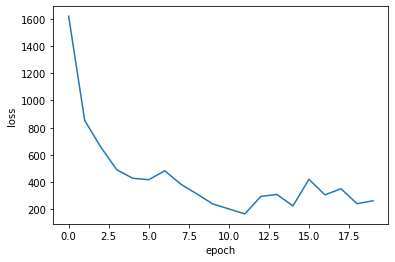

epoch 0 loss: 951.424072265625
epoch 1 loss: 552.61279296875
epoch 2 loss: 449.9200134277344
epoch 3 loss: 394.54034423828125
epoch 4 loss: 358.42352294921875
epoch 5 loss: 329.0762634277344
epoch 6 loss: 307.16888427734375
epoch 7 loss: 287.37457275390625
epoch 8 loss: 270.562744140625
epoch 9 loss: 254.5159149169922
epoch 10 loss: 242.13302612304688
epoch 11 loss: 227.84288024902344
epoch 12 loss: 217.01632690429688
epoch 13 loss: 205.95938110351562
epoch 14 loss: 197.00588989257812
epoch 15 loss: 186.45774841308594
epoch 16 loss: 179.30091857910156
epoch 17 loss: 170.6748046875
epoch 18 loss: 166.4815216064453
epoch 19 loss: 160.68743896484375


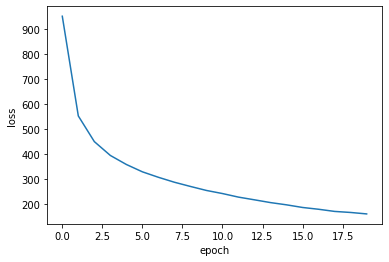

epoch 0 loss: 1517.9642333984375
epoch 1 loss: 974.4025268554688
epoch 2 loss: 812.7677001953125
epoch 3 loss: 687.4251098632812
epoch 4 loss: 601.591552734375
epoch 5 loss: 542.4796142578125
epoch 6 loss: 481.9950866699219
epoch 7 loss: 436.61041259765625
epoch 8 loss: 393.72607421875
epoch 9 loss: 356.07440185546875
epoch 10 loss: 326.5165710449219
epoch 11 loss: 299.6394348144531
epoch 12 loss: 275.9383239746094
epoch 13 loss: 266.4326477050781
epoch 14 loss: 263.4932861328125
epoch 15 loss: 239.2924346923828
epoch 16 loss: 229.37425231933594
epoch 17 loss: 230.0576171875
epoch 18 loss: 203.23858642578125
epoch 19 loss: 187.59014892578125


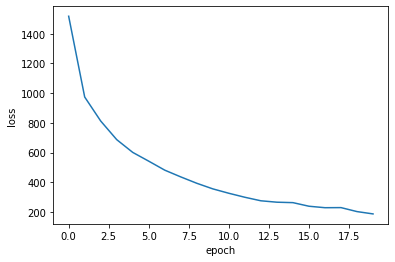

epoch 0 loss: 1268.12841796875
epoch 1 loss: 599.8486938476562
epoch 2 loss: 516.7249145507812
epoch 3 loss: 461.3572692871094
epoch 4 loss: 420.45294189453125
epoch 5 loss: 386.7971496582031
epoch 6 loss: 356.2232666015625
epoch 7 loss: 328.8147888183594
epoch 8 loss: 309.25726318359375
epoch 9 loss: 287.7418518066406
epoch 10 loss: 272.5403137207031
epoch 11 loss: 258.02886962890625
epoch 12 loss: 242.9614715576172
epoch 13 loss: 232.26913452148438
epoch 14 loss: 221.88311767578125
epoch 15 loss: 211.02943420410156
epoch 16 loss: 203.44308471679688
epoch 17 loss: 194.24513244628906
epoch 18 loss: 185.64918518066406
epoch 19 loss: 178.16070556640625


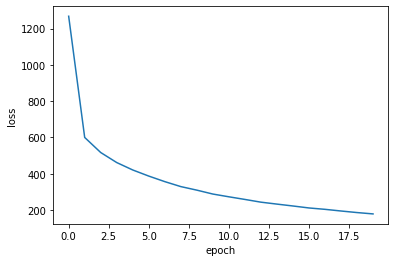

epoch 0 loss: 1371.29638671875
epoch 1 loss: 1004.5654907226562
epoch 2 loss: 849.7939453125
epoch 3 loss: 734.1692504882812
epoch 4 loss: 656.9210815429688
epoch 5 loss: 595.3201904296875
epoch 6 loss: 545.2457885742188
epoch 7 loss: 492.4558410644531
epoch 8 loss: 451.843017578125
epoch 9 loss: 420.572021484375
epoch 10 loss: 407.793701171875
epoch 11 loss: 376.3388977050781
epoch 12 loss: 354.5837097167969
epoch 13 loss: 339.8756103515625
epoch 14 loss: 317.8521728515625
epoch 15 loss: 295.1011962890625
epoch 16 loss: 278.5845947265625
epoch 17 loss: 270.6759338378906
epoch 18 loss: 258.2728576660156
epoch 19 loss: 245.58670043945312


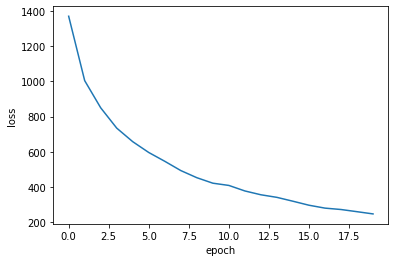

epoch 0 loss: 3293.94384765625
epoch 1 loss: 2011.12841796875
epoch 2 loss: 1207.255615234375
epoch 3 loss: 929.322509765625
epoch 4 loss: 864.8072509765625
epoch 5 loss: 835.643798828125
epoch 6 loss: 810.696044921875
epoch 7 loss: 787.0872802734375
epoch 8 loss: 764.4677734375
epoch 9 loss: 742.9234008789062
epoch 10 loss: 722.5879516601562
epoch 11 loss: 703.0177612304688
epoch 12 loss: 684.0521850585938
epoch 13 loss: 665.9848022460938
epoch 14 loss: 648.679931640625
epoch 15 loss: 632.1641845703125
epoch 16 loss: 616.4654541015625
epoch 17 loss: 601.3309936523438
epoch 18 loss: 586.707275390625
epoch 19 loss: 573.39892578125


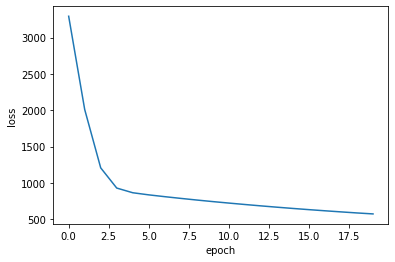

epoch 0 loss: 2247.474853515625
epoch 1 loss: 1746.3656005859375
epoch 2 loss: 1647.6949462890625
epoch 3 loss: 1555.5516357421875
epoch 4 loss: 1473.2373046875
epoch 5 loss: 1398.2672119140625
epoch 6 loss: 1330.75146484375
epoch 7 loss: 1271.497802734375
epoch 8 loss: 1218.2015380859375
epoch 9 loss: 1168.7440185546875
epoch 10 loss: 1124.5247802734375
epoch 11 loss: 1085.640625
epoch 12 loss: 1050.75634765625
epoch 13 loss: 1020.3126831054688
epoch 14 loss: 991.4271850585938
epoch 15 loss: 966.1242065429688
epoch 16 loss: 941.9180297851562
epoch 17 loss: 918.81640625
epoch 18 loss: 897.2451171875
epoch 19 loss: 876.7418212890625


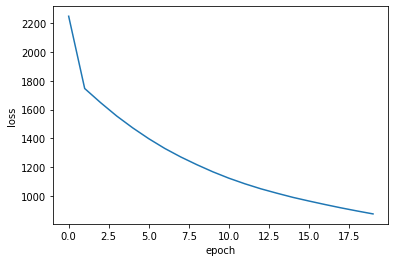

epoch 0 loss: 4423.3369140625
epoch 1 loss: 3289.99853515625
epoch 2 loss: 2186.29443359375
epoch 3 loss: 1291.8480224609375
epoch 4 loss: 884.7140502929688
epoch 5 loss: 799.3475341796875
epoch 6 loss: 773.3150024414062
epoch 7 loss: 752.788818359375
epoch 8 loss: 733.0924682617188
epoch 9 loss: 714.5520629882812
epoch 10 loss: 696.834228515625
epoch 11 loss: 679.8102416992188
epoch 12 loss: 663.9044189453125
epoch 13 loss: 648.7586059570312
epoch 14 loss: 634.4912109375
epoch 15 loss: 620.9830932617188
epoch 16 loss: 608.3189086914062
epoch 17 loss: 596.2499389648438
epoch 18 loss: 584.6411743164062
epoch 19 loss: 574.0355224609375


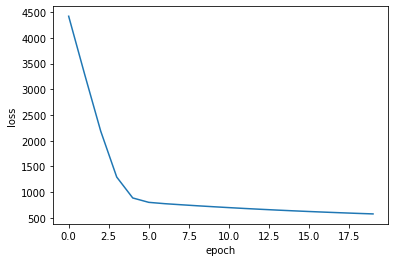

epoch 0 loss: 3407.5185546875
epoch 1 loss: 1662.20166015625
epoch 2 loss: 1458.2354736328125
epoch 3 loss: 1381.6290283203125
epoch 4 loss: 1313.2330322265625
epoch 5 loss: 1254.3194580078125
epoch 6 loss: 1202.237548828125
epoch 7 loss: 1156.919677734375
epoch 8 loss: 1117.281982421875
epoch 9 loss: 1081.7249755859375
epoch 10 loss: 1049.356689453125
epoch 11 loss: 1019.6821899414062
epoch 12 loss: 991.7496337890625
epoch 13 loss: 966.9142456054688
epoch 14 loss: 943.3232421875
epoch 15 loss: 921.6739501953125
epoch 16 loss: 902.9415283203125
epoch 17 loss: 884.6639404296875
epoch 18 loss: 866.7086791992188
epoch 19 loss: 850.49560546875


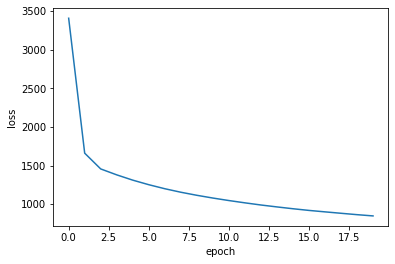

epoch 0 loss: 1421.9017333984375
epoch 1 loss: 727.125244140625
epoch 2 loss: 643.2376708984375
epoch 3 loss: 577.618408203125
epoch 4 loss: 528.4590454101562
epoch 5 loss: 488.25372314453125
epoch 6 loss: 454.2535400390625
epoch 7 loss: 424.3587646484375
epoch 8 loss: 398.628662109375
epoch 9 loss: 378.0621643066406
epoch 10 loss: 358.7496032714844
epoch 11 loss: 344.033447265625
epoch 12 loss: 328.3034973144531
epoch 13 loss: 316.3127746582031
epoch 14 loss: 303.8104248046875
epoch 15 loss: 292.1907653808594
epoch 16 loss: 282.8189392089844
epoch 17 loss: 273.6094055175781
epoch 18 loss: 264.15826416015625
epoch 19 loss: 255.84658813476562


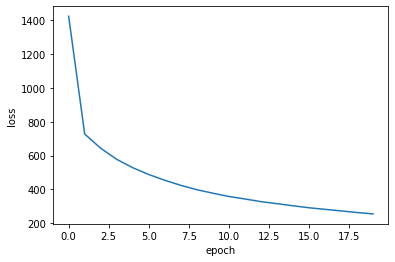

epoch 0 loss: 3296.29296875
epoch 1 loss: 1352.97119140625
epoch 2 loss: 1155.662109375
epoch 3 loss: 1027.7823486328125
epoch 4 loss: 939.3179321289062
epoch 5 loss: 869.84326171875
epoch 6 loss: 803.0977783203125
epoch 7 loss: 749.21826171875
epoch 8 loss: 703.0988159179688
epoch 9 loss: 660.9552612304688
epoch 10 loss: 624.4003295898438
epoch 11 loss: 590.1498413085938
epoch 12 loss: 559.6470336914062
epoch 13 loss: 535.238525390625
epoch 14 loss: 511.47998046875
epoch 15 loss: 494.39447021484375
epoch 16 loss: 477.01971435546875
epoch 17 loss: 455.41009521484375
epoch 18 loss: 440.33209228515625
epoch 19 loss: 425.9976501464844


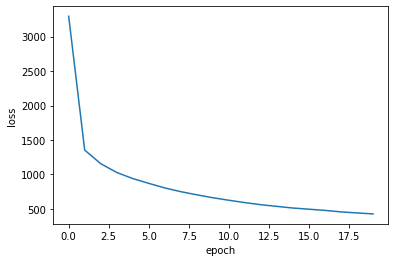

epoch 0 loss: 3830.375
epoch 1 loss: 1453.658203125
epoch 2 loss: 760.5762939453125
epoch 3 loss: 648.3267822265625
epoch 4 loss: 570.5870361328125
epoch 5 loss: 520.083251953125
epoch 6 loss: 484.9227294921875
epoch 7 loss: 456.2239074707031
epoch 8 loss: 431.94561767578125
epoch 9 loss: 411.13226318359375
epoch 10 loss: 394.3125305175781
epoch 11 loss: 378.7483215332031
epoch 12 loss: 364.35174560546875
epoch 13 loss: 351.1219787597656
epoch 14 loss: 339.6104431152344
epoch 15 loss: 328.55328369140625
epoch 16 loss: 318.07147216796875
epoch 17 loss: 309.6413879394531
epoch 18 loss: 300.9827575683594
epoch 19 loss: 293.8542785644531


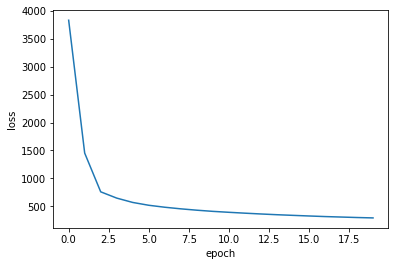

epoch 0 loss: 2420.29150390625
epoch 1 loss: 1293.1622314453125
epoch 2 loss: 1115.718017578125
epoch 3 loss: 991.0298461914062
epoch 4 loss: 899.7413330078125
epoch 5 loss: 824.5481567382812
epoch 6 loss: 767.2207641601562
epoch 7 loss: 712.5272216796875
epoch 8 loss: 664.3578491210938
epoch 9 loss: 627.019287109375
epoch 10 loss: 587.7357788085938
epoch 11 loss: 552.1170654296875
epoch 12 loss: 522.2987060546875
epoch 13 loss: 495.36126708984375
epoch 14 loss: 470.6377868652344
epoch 15 loss: 451.6737365722656
epoch 16 loss: 429.1703796386719
epoch 17 loss: 412.9982604980469
epoch 18 loss: 395.92291259765625
epoch 19 loss: 383.6755065917969


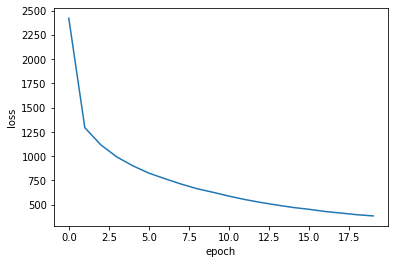

In [ ]:
from engine import hyper_parameters_search
import itertools

def get_hyper_parameters_baseline():
    learning_rate = [0.0005, 0.0001, 0.00001, 0.00005]
    weight_decay = [0.001, 0.005]
    hidden_dim = [[1024, 1024], [2048, 2048]]
    return itertools.product(learning_rate, weight_decay, hidden_dim)

hyper_param_baseline = get_hyper_parameters_baseline()

lr, weight_decay, hidden_dim = hyper_parameters_search(
    'baseline',
    hyper_param_baseline,
    val_loader,
    20)

In [ ]:
print(lr, weight_decay, hidden_dim) #0.0005 0.005 [1024, 1024]

0.0005 0.005 [1024, 1024]


In [ ]:
#lr, weight_decay, hidden_dim = (0.001, 0.0001, [1024, 1024]) # Best from hyperParameterSearch
from torch.optim import Adam

baseline_model = MediaBiasNN(hidden_dim, model_type="baseline")
model_params = [param for param in baseline_model.parameters() if param.requires_grad]
optimizer = Adam(model_params, lr=lr, weight_decay=weight_decay)

epoch 0 train loss: 473.17529296875 val loss: 448.6689758300781 test acc: 0.429500013589859 test f1: 0.3659120500087738
epoch 1 train loss: 295.5468444824219 val loss: 287.0636901855469 test acc: 0.46650001406669617 test f1: 0.4486198425292969
epoch 2 train loss: 229.0189666748047 val loss: 256.2555236816406 test acc: 0.47450000047683716 test f1: 0.46318018436431885
epoch 3 train loss: 192.43209838867188 val loss: 246.05465698242188 test acc: 0.48249998688697815 test f1: 0.46131205558776855
epoch 4 train loss: 166.98573303222656 val loss: 234.6966552734375 test acc: 0.4819999933242798 test f1: 0.46184995770454407
epoch 5 train loss: 142.54750061035156 val loss: 221.76844787597656 test acc: 0.4894999861717224 test f1: 0.464069128036499
epoch 6 train loss: 128.1381072998047 val loss: 228.17074584960938 test acc: 0.4934999942779541 test f1: 0.4606989920139313
epoch 7 train loss: 128.78607177734375 val loss: 209.9729766845703 test acc: 0.515999972820282 test f1: 0.490105003118515
epoch 8 t

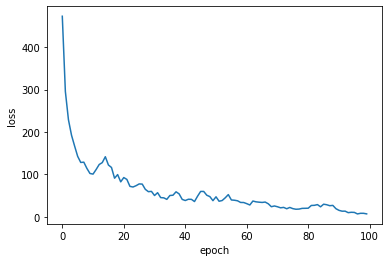

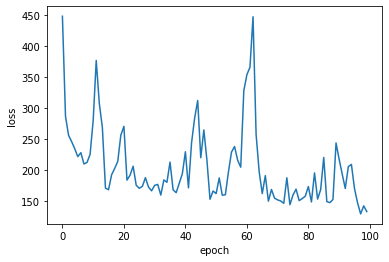

In [ ]:
from engine import train_model
BASELINE_PATH = Path("./baseline_model")
train_model(baseline_model, train_loader, val_loader, test_loader, optimizer, 100, BASELINE_PATH)

epoch 0 loss: 341.4747314453125
epoch 1 loss: 92.6842269897461
epoch 2 loss: 112.16559600830078
epoch 3 loss: 126.77326965332031
epoch 4 loss: 69.84940338134766
epoch 5 loss: 49.230079650878906
epoch 6 loss: 40.197566986083984
epoch 7 loss: 30.527013778686523
epoch 8 loss: 32.217620849609375
epoch 9 loss: 28.210512161254883
epoch 10 loss: 28.347299575805664
epoch 11 loss: 26.704416275024414
epoch 12 loss: 19.41929817199707
epoch 13 loss: 23.613937377929688
epoch 14 loss: 19.99420738220215
epoch 15 loss: 39.56748962402344
epoch 16 loss: 50.236732482910156
epoch 17 loss: 37.21282196044922
epoch 18 loss: 27.319063186645508
epoch 19 loss: 26.326501846313477


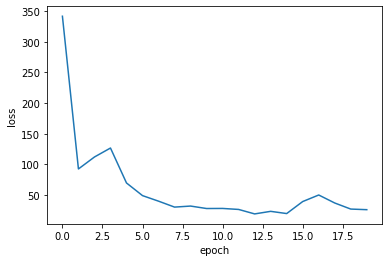

epoch 0 loss: 1230.3206787109375
epoch 1 loss: 177.48902893066406
epoch 2 loss: 129.2756805419922
epoch 3 loss: 113.34612274169922
epoch 4 loss: 120.17475891113281
epoch 5 loss: 87.08478546142578
epoch 6 loss: 107.65276336669922
epoch 7 loss: 103.84925079345703
epoch 8 loss: 134.82180786132812
epoch 9 loss: 73.16380310058594
epoch 10 loss: 75.86243438720703
epoch 11 loss: 58.264888763427734
epoch 12 loss: 57.914642333984375
epoch 13 loss: 29.076841354370117
epoch 14 loss: 44.23023223876953
epoch 15 loss: 33.12458801269531
epoch 16 loss: 32.437198638916016
epoch 17 loss: 29.812562942504883
epoch 18 loss: 30.100229263305664
epoch 19 loss: 21.77146339416504


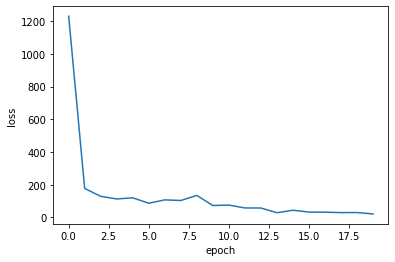

epoch 0 loss: 425.8397521972656
epoch 1 loss: 96.2959976196289
epoch 2 loss: 90.51834106445312
epoch 3 loss: 76.89178466796875
epoch 4 loss: 91.49800872802734
epoch 5 loss: 48.60213088989258
epoch 6 loss: 30.587142944335938
epoch 7 loss: 40.10892105102539
epoch 8 loss: 26.914878845214844
epoch 9 loss: 44.429840087890625
epoch 10 loss: 59.376644134521484
epoch 11 loss: 65.10993194580078
epoch 12 loss: 46.91041564941406
epoch 13 loss: 37.176307678222656
epoch 14 loss: 29.5364990234375
epoch 15 loss: 24.702964782714844
epoch 16 loss: 17.629255294799805
epoch 17 loss: 20.206661224365234
epoch 18 loss: 16.460716247558594
epoch 19 loss: 16.00661277770996


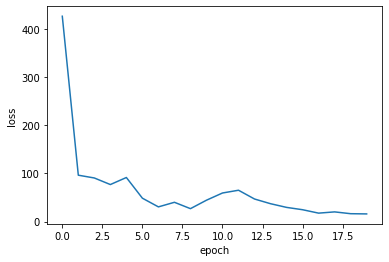

epoch 0 loss: 890.7222290039062
epoch 1 loss: 263.5987854003906
epoch 2 loss: 221.61492919921875
epoch 3 loss: 124.87767028808594
epoch 4 loss: 106.2261734008789
epoch 5 loss: 96.62081909179688
epoch 6 loss: 88.1953125
epoch 7 loss: 75.96410369873047
epoch 8 loss: 61.01127624511719
epoch 9 loss: 77.7032699584961
epoch 10 loss: 57.89653396606445
epoch 11 loss: 54.91116714477539
epoch 12 loss: 52.96904373168945
epoch 13 loss: 41.87253952026367
epoch 14 loss: 41.139923095703125
epoch 15 loss: 38.79974365234375
epoch 16 loss: 26.093473434448242
epoch 17 loss: 22.333904266357422
epoch 18 loss: 29.217100143432617
epoch 19 loss: 38.936466217041016


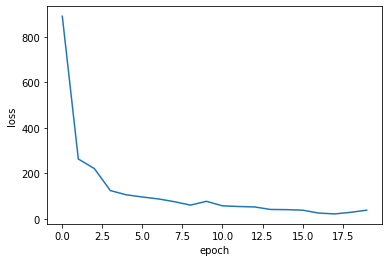

epoch 0 loss: 143.3748779296875
epoch 1 loss: 59.39669418334961
epoch 2 loss: 49.7293586730957
epoch 3 loss: 52.79436111450195
epoch 4 loss: 26.07874870300293
epoch 5 loss: 22.038679122924805
epoch 6 loss: 17.129030227661133
epoch 7 loss: 23.212209701538086
epoch 8 loss: 14.538372993469238
epoch 9 loss: 17.899898529052734
epoch 10 loss: 34.671695709228516
epoch 11 loss: 33.56440734863281
epoch 12 loss: 26.372344970703125
epoch 13 loss: 32.716793060302734
epoch 14 loss: 24.440048217773438
epoch 15 loss: 29.05503273010254
epoch 16 loss: 20.72420310974121
epoch 17 loss: 23.390823364257812
epoch 18 loss: 16.468202590942383
epoch 19 loss: 11.819733619689941


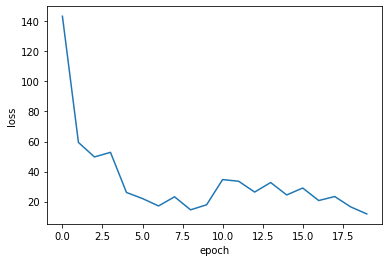

epoch 0 loss: 363.1844787597656
epoch 1 loss: 142.3557586669922
epoch 2 loss: 135.24761962890625
epoch 3 loss: 54.20054244995117
epoch 4 loss: 70.25672912597656
epoch 5 loss: 95.11042022705078
epoch 6 loss: 40.95743942260742
epoch 7 loss: 46.9422492980957
epoch 8 loss: 62.42121124267578
epoch 9 loss: 52.903053283691406
epoch 10 loss: 83.89057922363281
epoch 11 loss: 77.42265319824219
epoch 12 loss: 73.46369171142578
epoch 13 loss: 70.09014892578125
epoch 14 loss: 75.29216003417969
epoch 15 loss: 57.44961166381836
epoch 16 loss: 51.18645477294922
epoch 17 loss: 30.106229782104492
epoch 18 loss: 19.849214553833008
epoch 19 loss: 18.648794174194336


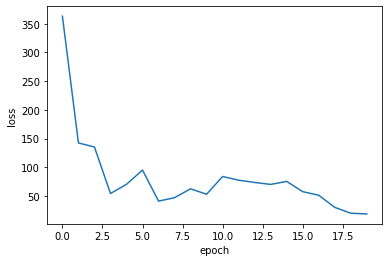

epoch 0 loss: 160.8643341064453
epoch 1 loss: 38.451927185058594
epoch 2 loss: 39.570980072021484
epoch 3 loss: 61.228572845458984
epoch 4 loss: 30.12930679321289
epoch 5 loss: 41.41262435913086
epoch 6 loss: 19.652366638183594
epoch 7 loss: 31.756101608276367
epoch 8 loss: 23.474149703979492
epoch 9 loss: 22.95391082763672
epoch 10 loss: 38.82510757446289
epoch 11 loss: 37.385128021240234
epoch 12 loss: 27.73147964477539
epoch 13 loss: 26.32101821899414
epoch 14 loss: 22.15778350830078
epoch 15 loss: 25.102018356323242
epoch 16 loss: 28.7589111328125
epoch 17 loss: 19.182077407836914
epoch 18 loss: 16.374677658081055
epoch 19 loss: 9.031950950622559


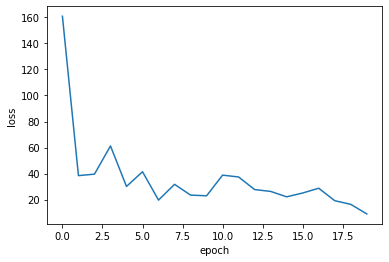

epoch 0 loss: 265.1144714355469
epoch 1 loss: 206.59974670410156
epoch 2 loss: 144.44134521484375
epoch 3 loss: 70.29225158691406
epoch 4 loss: 81.45835876464844
epoch 5 loss: 89.0439682006836
epoch 6 loss: 74.05384063720703
epoch 7 loss: 106.67703247070312
epoch 8 loss: 54.82012176513672
epoch 9 loss: 70.3204574584961
epoch 10 loss: 85.7648696899414
epoch 11 loss: 75.44020080566406
epoch 12 loss: 91.89906311035156
epoch 13 loss: 79.49414825439453
epoch 14 loss: 57.699134826660156
epoch 15 loss: 45.81971740722656
epoch 16 loss: 69.13329315185547
epoch 17 loss: 51.33216094970703
epoch 18 loss: 26.376174926757812
epoch 19 loss: 21.483362197875977


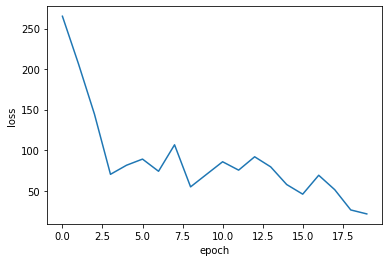

epoch 0 loss: 182.1656494140625
epoch 1 loss: 60.846256256103516
epoch 2 loss: 47.884429931640625
epoch 3 loss: 40.12557601928711
epoch 4 loss: 33.49816131591797
epoch 5 loss: 29.258169174194336
epoch 6 loss: 25.50425910949707
epoch 7 loss: 22.97103500366211
epoch 8 loss: 22.26696014404297
epoch 9 loss: 20.70515251159668
epoch 10 loss: 20.700143814086914
epoch 11 loss: 18.761133193969727
epoch 12 loss: 16.218883514404297
epoch 13 loss: 15.45683479309082
epoch 14 loss: 14.633076667785645
epoch 15 loss: 16.431520462036133
epoch 16 loss: 18.4549560546875
epoch 17 loss: 16.292461395263672
epoch 18 loss: 14.80915355682373
epoch 19 loss: 13.563963890075684


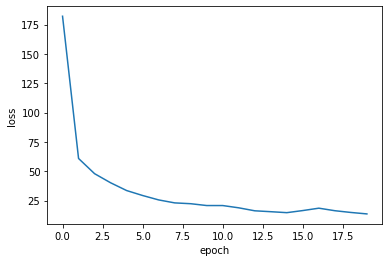

epoch 0 loss: 186.70175170898438
epoch 1 loss: 110.06136322021484
epoch 2 loss: 81.80089569091797
epoch 3 loss: 66.44155883789062
epoch 4 loss: 54.98866271972656
epoch 5 loss: 46.9659309387207
epoch 6 loss: 43.65857696533203
epoch 7 loss: 38.932456970214844
epoch 8 loss: 34.149173736572266
epoch 9 loss: 33.509361267089844
epoch 10 loss: 31.02886390686035
epoch 11 loss: 35.12001037597656
epoch 12 loss: 47.96904754638672
epoch 13 loss: 44.00906753540039
epoch 14 loss: 32.86144256591797
epoch 15 loss: 22.974815368652344
epoch 16 loss: 19.324756622314453
epoch 17 loss: 19.8291015625
epoch 18 loss: 24.781978607177734
epoch 19 loss: 25.49761390686035


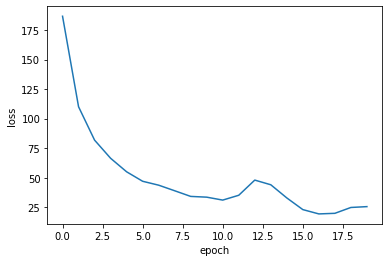

epoch 0 loss: 128.8852996826172
epoch 1 loss: 58.00543212890625
epoch 2 loss: 43.45011520385742
epoch 3 loss: 34.7990608215332
epoch 4 loss: 28.977340698242188
epoch 5 loss: 25.038774490356445
epoch 6 loss: 22.522268295288086
epoch 7 loss: 20.362348556518555
epoch 8 loss: 18.130712509155273
epoch 9 loss: 15.602330207824707
epoch 10 loss: 14.402868270874023
epoch 11 loss: 13.386427879333496
epoch 12 loss: 12.059494972229004
epoch 13 loss: 13.545048713684082
epoch 14 loss: 14.722235679626465
epoch 15 loss: 12.732276916503906
epoch 16 loss: 10.619833946228027
epoch 17 loss: 10.190192222595215
epoch 18 loss: 10.210926055908203
epoch 19 loss: 9.670968055725098


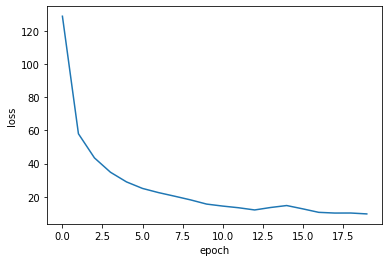

epoch 0 loss: 178.39903259277344
epoch 1 loss: 113.56394958496094
epoch 2 loss: 89.91962432861328
epoch 3 loss: 77.982421875
epoch 4 loss: 67.45299530029297
epoch 5 loss: 60.801292419433594
epoch 6 loss: 55.26286315917969
epoch 7 loss: 60.83259963989258
epoch 8 loss: 61.61455154418945
epoch 9 loss: 53.851844787597656
epoch 10 loss: 42.939048767089844
epoch 11 loss: 41.12115478515625
epoch 12 loss: 46.32061767578125
epoch 13 loss: 48.61796188354492
epoch 14 loss: 49.746681213378906
epoch 15 loss: 47.79042053222656
epoch 16 loss: 33.56035232543945
epoch 17 loss: 35.06729507446289
epoch 18 loss: 36.49874496459961
epoch 19 loss: 27.65818977355957


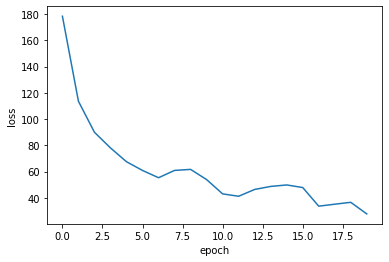

epoch 0 loss: 105.78577423095703
epoch 1 loss: 57.07770538330078
epoch 2 loss: 37.86060333251953
epoch 3 loss: 36.07146453857422
epoch 4 loss: 27.371219635009766
epoch 5 loss: 30.04963493347168
epoch 6 loss: 23.818523406982422
epoch 7 loss: 27.553726196289062
epoch 8 loss: 25.33928871154785
epoch 9 loss: 33.46189880371094
epoch 10 loss: 27.945466995239258
epoch 11 loss: 23.48680877685547
epoch 12 loss: 14.617886543273926
epoch 13 loss: 14.620427131652832
epoch 14 loss: 14.274822235107422
epoch 15 loss: 16.554025650024414
epoch 16 loss: 26.063554763793945
epoch 17 loss: 21.477020263671875
epoch 18 loss: 22.297788619995117
epoch 19 loss: 28.97315788269043


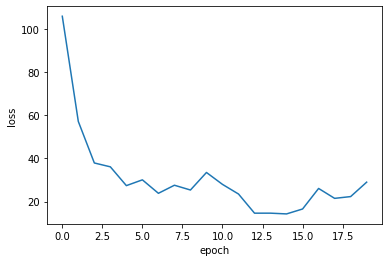

epoch 0 loss: 243.08712768554688
epoch 1 loss: 118.32711791992188
epoch 2 loss: 65.56734466552734
epoch 3 loss: 48.293601989746094
epoch 4 loss: 52.86753463745117
epoch 5 loss: 64.70427703857422
epoch 6 loss: 55.95588302612305
epoch 7 loss: 72.13288116455078
epoch 8 loss: 75.21406555175781
epoch 9 loss: 68.1949462890625
epoch 10 loss: 63.00400924682617
epoch 11 loss: 32.235164642333984
epoch 12 loss: 46.09672546386719
epoch 13 loss: 53.05530548095703
epoch 14 loss: 53.498573303222656
epoch 15 loss: 76.13777160644531
epoch 16 loss: 71.59229278564453
epoch 17 loss: 59.04090118408203
epoch 18 loss: 43.030555725097656
epoch 19 loss: 38.981422424316406


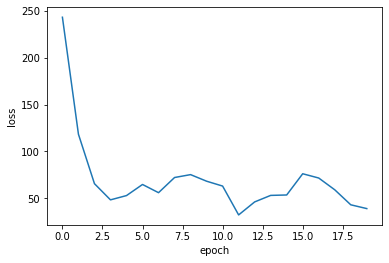

epoch 0 loss: 117.96282958984375
epoch 1 loss: 52.83864974975586
epoch 2 loss: 42.09959411621094
epoch 3 loss: 32.08837890625
epoch 4 loss: 22.496225357055664
epoch 5 loss: 32.88949966430664
epoch 6 loss: 22.946794509887695
epoch 7 loss: 20.917600631713867
epoch 8 loss: 29.913734436035156
epoch 9 loss: 20.603727340698242
epoch 10 loss: 24.46613121032715
epoch 11 loss: 18.02312660217285
epoch 12 loss: 27.09162712097168
epoch 13 loss: 37.755252838134766
epoch 14 loss: 35.15079116821289
epoch 15 loss: 32.300533294677734
epoch 16 loss: 15.494736671447754
epoch 17 loss: 17.764089584350586
epoch 18 loss: 29.97334861755371
epoch 19 loss: 20.376813888549805


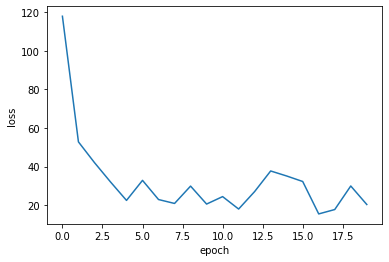

epoch 0 loss: 170.10850524902344
epoch 1 loss: 96.83416748046875
epoch 2 loss: 69.47119140625
epoch 3 loss: 86.15282440185547
epoch 4 loss: 54.75895309448242
epoch 5 loss: 61.94138717651367
epoch 6 loss: 53.75679397583008
epoch 7 loss: 74.03981018066406
epoch 8 loss: 67.61676788330078
epoch 9 loss: 81.67933654785156
epoch 10 loss: 55.439414978027344
epoch 11 loss: 43.44807052612305
epoch 12 loss: 35.502071380615234
epoch 13 loss: 31.997547149658203
epoch 14 loss: 27.146488189697266
epoch 15 loss: 39.46986389160156
epoch 16 loss: 39.24348831176758
epoch 17 loss: 50.79642105102539
epoch 18 loss: 66.7987289428711
epoch 19 loss: 73.7829818725586


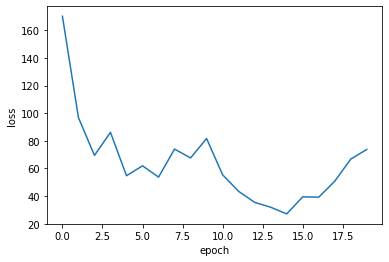

In [ ]:
def get_hyper_parameters_rnn():
    learning_rate = [0.0005, 0.0001, 0.00001, 0.00005]
    weight_decay = [0.0001, 0.0005]
    hidden_dim = [[1024, 1024], [2048, 2048]]
    return itertools.product(learning_rate, weight_decay, hidden_dim)

hyper_param_rnn = get_hyper_parameters_rnn()

lr, weight_decay, hidden_dim = hyper_parameters_search(
    'rnn',
    hyper_param_rnn,
    val_loader,
    20)

In [ ]:
print(lr, weight_decay, hidden_dim) #0.0001 0.0005 [1024, 1024]

0.0001 0.0005 [1024, 1024]


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
!nvidia-smi

Tue Apr 19 06:06:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    61W / 300W |   5043MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch 0 train loss: 21.655576705932617 val loss: 19.164794921875 test acc: 0.42100000381469727 test f1: 0.35040539503097534
epoch 1 train loss: 8.998745918273926 val loss: 5.7001051902771 test acc: 0.5239999890327454 test f1: 0.5196892619132996
epoch 2 train loss: 5.4814133644104 val loss: 9.515970230102539 test acc: 0.4255000054836273 test f1: 0.3386552929878235
epoch 3 train loss: 5.862546920776367 val loss: 5.077114105224609 test acc: 0.5074999928474426 test f1: 0.48549216985702515
epoch 4 train loss: 4.865638256072998 val loss: 9.216750144958496 test acc: 0.44850000739097595 test f1: 0.3974057137966156
epoch 5 train loss: 4.018398761749268 val loss: 6.041414737701416 test acc: 0.44850000739097595 test f1: 0.3788568377494812
epoch 6 train loss: 3.361609697341919 val loss: 4.106575965881348 test acc: 0.515500009059906 test f1: 0.49516794085502625
epoch 7 train loss: 2.49985671043396 val loss: 4.723935604095459 test acc: 0.48249998688697815 test f1: 0.4346127212047577
epoch 8 train lo

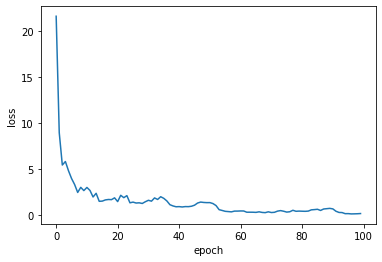

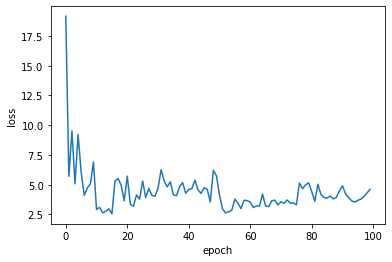

In [ ]:
RNN_PATH = Path("./rnn_model")
rnn_model = MediaBiasNN(hidden_dim, model_type="rnn", lstm_layers=2, lstm_hidden_dim=1024)
model_params = [param for param in rnn_model.parameters() if param.requires_grad]
optimizer = Adam(model_params, lr=lr, weight_decay=weight_decay)
train_model(rnn_model, train_loader, val_loader, test_loader, optimizer, 100, RNN_PATH)